In [1]:
import sys
from time import time
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:99% !important; }</style>"))

### Load the measurements and production data.

In [2]:
# specify time range and number of production events
time_range_key = '1d'
prod_count = 1000 if time_range_key == '1y' else 100 if time_range_key == '1m' else 10

In [3]:
# all data will be read from or stored under this folder
DATA_DIR = Path('data')

measurements_file = DATA_DIR / F"measurements-dummy-{time_range_key}.csv"
prod_file = DATA_DIR / F"production-dummy-{prod_count}-{time_range_key}.csv"

In [4]:
measure_df = pd.read_csv(measurements_file)
measure_df['timestamp'] = measure_df['timestamp'].apply(lambda x: pd.Timestamp(x))
measure_df.head()

,timestamp,m1,m2,m3,m4,m5
0,2018-01-01 00:00:00,66.780494,65.217221,48.842714,51.054600,56.330693
1,2018-01-01 00:00:30,57.675873,82.594139,67.128019,34.646194,49.404110
2,2018-01-01 00:01:00,65.254882,51.663527,49.967143,53.994720,27.718782
3,2018-01-01 00:01:30,48.868397,23.830365,63.191482,53.418901,61.711849
4,2018-01-01 00:02:00,55.270477,16.035617,46.767995,31.731472,60.183277


In [5]:
prod_df = pd.read_csv(prod_file)
prod_df['finished_time'] = prod_df['finished_time'].apply(lambda x: pd.Timestamp(x))
prod_df.head()

,duration,finished_time,efficiency
0,90,2018-01-01 03:00:04,51.108762
1,90,2018-01-01 04:30:06,27.203295
2,90,2018-01-01 06:00:08,98.806322
3,90,2018-01-01 09:00:12,50.763437
4,90,2018-01-01 10:30:14,53.172586


### Merge v1

In [25]:
nano2sec = lambda x: x / 10 ** 9 # convert nanoseconds to seconds
nano2milli = lambda x: x / 10 ** 6  # convert nanoseconds to milliseconds

def merge_v1(ts, prod_df):
    '''
    add to each measurement the production finished time
    if (measure.timestamp > finished_time - duration) and (measure.timestamp < finished_time)
    '''
    t0 = pd.Timestamp.now()
    prod_results = prod_df.loc[(ts <= prod_df.finished_time) & (ts >= prod_df.finished_time - pd.Timedelta(minutes=90))]
    t = (pd.Timestamp.now() - t0).value
    if prod_results.size == 0:
        return pd.Series({'finished_time': None, 'debug_time': t})
    else:
        return pd.Series({'finished_time': prod_results.iloc[0].finished_time, 'debug_time': t})

t0 = pd.Timestamp.now()
measure_df[['finished_time', 'debug_time']] = measure_df['timestamp'].apply(lambda ts: merge_v1(ts, prod_df))
measure_df['debug_time_ms'] = measure_df.debug_time.apply(lambda x: nano2milli(x))
t = (pd.Timestamp.now() - t0).value

print('Done! Total time: {0:.4f}s, Time per measurement: {1:.4f}ms'.format(nano2sec(t), nano2milli(t) / measure_df.shape[0]))

measure_df.head(10)

Done! Total time: 11.3038s, Time per measurement: 3.9249ms


,timestamp,m1,m2,m3,m4,m5,finished_time,debug_time,debug_time_ms
0,2018-01-01 00:00:00,66.780494,65.217221,48.842714,51.054600,56.330693,NaT,3998000.0,3.998
1,2018-01-01 00:00:30,57.675873,82.594139,67.128019,34.646194,49.404110,NaT,3999000.0,3.999
2,2018-01-01 00:01:00,65.254882,51.663527,49.967143,53.994720,27.718782,NaT,3998000.0,3.998
3,2018-01-01 00:01:30,48.868397,23.830365,63.191482,53.418901,61.711849,NaT,3998000.0,3.998
4,2018-01-01 00:02:00,55.270477,16.035617,46.767995,31.731472,60.183277,NaT,3998000.0,3.998
5,2018-01-01 00:02:30,90.993282,65.538728,66.939610,31.225604,47.898509,NaT,4003000.0,4.003
6,2018-01-01 00:03:00,53.247141,57.772422,46.519145,48.474841,33.584204,NaT,3989000.0,3.989
7,2018-01-01 00:03:30,61.078843,34.535699,45.316311,24.901166,65.901114,NaT,2998000.0,2.998
8,2018-01-01 00:04:00,44.674500,55.189079,34.085690,35.149121,37.953871,NaT,2998000.0,2.998
9,2018-01-01 00:04:30,57.911878,51.677746,45.655924,75.952376,25.007941,NaT,3000000.0,3.000


In [26]:
measure_df.debug_time_ms.describe(percentiles=[.25, .5, .75, .9, .95, .99]).T

count    2880.000000
mean        3.183292
std         1.477636
min         1.999000
25%         2.998000
50%         2.999000
75%         3.000000
90%         3.998000
95%         3.999000
99%         4.000000
max        79.963000
Name: debug_time_ms, dtype: float64

In [91]:
selected_measure_df = measure_df.loc[measure_df.finished_time != None]
selected_measure_df.to_csv('selected_measurements.tsv', sep='\t', index=False)

In [62]:
prod_results.iloc[0].finished_time

Timestamp('2018-01-01 10:30:14')

In [78]:
t0 = pd.Timestamp.now()

In [79]:
t1 = pd.Timestamp.now()

In [87]:
td = t1 - t0

In [94]:
nano2sec = lambda x: x / 10 ** 9 # convert nanoseconds to seconds
nano2milli = lambda x: int(x / 10 ** 6)  # convert nanoseconds to milliseconds

nano2milli(3998000)

3

In [95]:
measure_df.debug_time.plot()

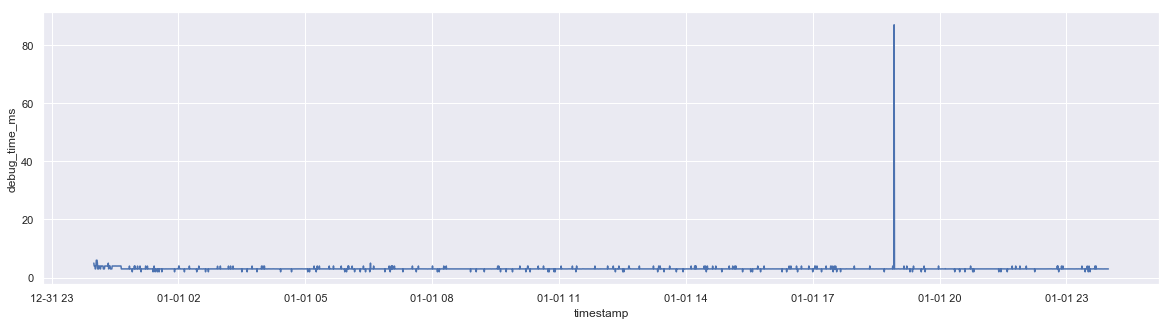

In [23]:
sns.set(rc={'figure.figsize':(20, 5)})

sns.lineplot(x="timestamp", y="debug_time_ms", data=measure_df)

In [7]:
print(sns.__version__)

0.9.0
